# Test E & C Index calcs

In [1]:
import sys
sys.path.append('../')

#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.timePeriod as tp

In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#import dask.config
#dask.config.set({"array.slicing.split_large_chunks": True})

from dask.distributed import Client, LocalCluster
client = Client()
print(client)

In [5]:
#load the full model set
modelSet=_model.scenarioMip

For all the models, calculate the alphas

In [6]:
%run ../utils/ecIndex.ipynb

FIO-ESM-2-0
'DataArray' object has no attribute 'lat'
GFDL-CM4


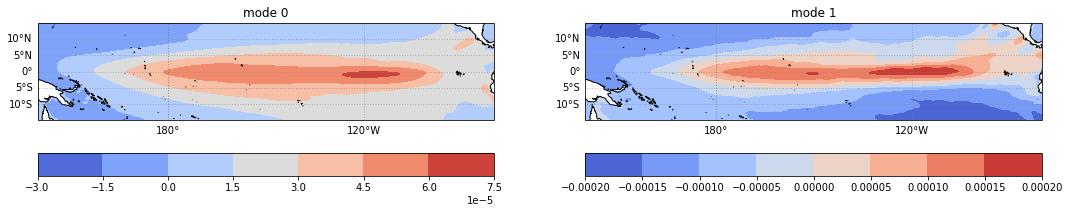

GFDL-ESM4


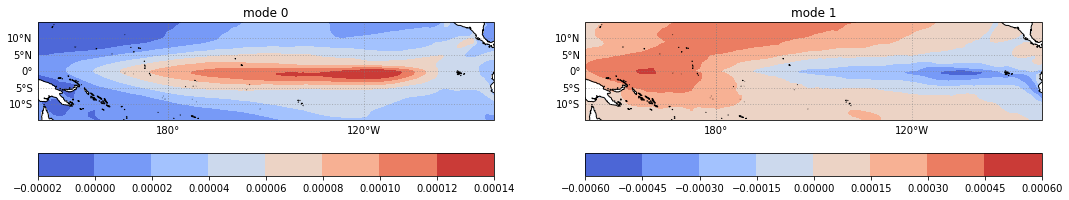

GISS-E2-1-G


In [ ]:

for iModel in modelSet[18:,:]:
    try:
        print(iModel[1])
        
        tsXr = xarray.concat([
            fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3]).tos, 
            fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3]).tos
        ], dim='time')
       
        sstAnomXr=sstAnoms(tsXr)

        sstAnomXr
        
        indeces, pFit, eofsXr = ecIndex(sstAnomXr)
        
        indeces
        
        indeces.to_netcdf('results/wangAlphas/index'+str(iModel[1])+'.nc')
        eofsXr.to_netcdf('results/wangAlphas/eof'+str(iModel[1])+'.nc')
        
        fig=plt.figure(figsize=(18,12))
        
        for mode in [0,1]:
            ax=fig.add_subplot(1,2,mode+1,
                           projection=ccrs.Miller(central_longitude=210))

            ensoPlotter(eofsXr.sel(mode=mode), ax)

            plt.title("mode " + str(mode))

        plt.show()

    except Exception as e:
        print(e)

In [ ]:
#multipliers - visual inspection
#sign is arbitrary in an EOF
# interpreting as mode 0: CP warming, mode 1: WP warming, EP cooling
multipliers={'ACCESS-CM2':[-1,-1], 
    'ACCESS-ESM1-5':[-1,1],
    'BCC-CSM2-MR':[1,-1],
    'CAMS-CSM1-0':[1,-1],
    'CAS-ESM2-0':[1,-1],
    'CESM2':[1,-1], 
    'CESM2-WACCM':[-1,1],
    'CIESM':[-1,-1], 
    'CMCC-CM2-SR5':[-1,1],
    'CMCC-ESM2':[-1,1], 
    'CNRM-CM6-1':[1,-1], 
    'CNRM-ESM2-1':[-1,-1], 
    'CanESM5':[-1,1],
    'CanESM5-CanOE':[1,-1], 
    'EC-Earth3':[1,1], 
    'EC-Earth3-CC':[1,-1], 
    'EC-Earth3-Veg':[1,1],
    'EC-Earth3-Veg-LR':[1,1], 
    'FIO-ESM-2-0':[-1,-1],
    'GFDL-CM4':[1,1], 
    'GFDL-ESM4':[1,-1], 
    'GISS-E2-1-G':[-1,-1],
    'HadGEM3-GC31-LL':[1,-1], 
    'HadGEM3-GC31-MM':[1,1], 
    'INM-CM4-8':[-1,-1], 
    'INM-CM5-0':[1,-1],
    'IPSL-CM6A-LR':[-1,-1], 
    'KACE-1-0-G':[1,-1], 
    'MCM-UA-1-0':[-1,-1], 
    'MIROC-ES2L':[-1,1], 
    'MIROC6':[1,1],
    'MPI-ESM1-2-HR':[1,1], 
    'MPI-ESM1-2-LR':[-1,1],
    'MRI-ESM2-0':[-1,-1], 
    'NESM3':[-1,-1],
    'NorESM2-LM':[-1,1], 
    'NorESM2-MM':[1,1], 
    'UKESM1-0-LL':[1,-1] 
    }

In [ ]:
alphas=dict()

for iModel in modelSet:
    import numpy.polynomial as poly
    try:
        print(iModel[1])
        
        indeces=xarray.load_dataset('results/wangAlphas/index'+str(iModel[1])+'.nc')
        eofsXr=xarray.load_dataarray('results/wangAlphas/eof'+str(iModel[1])+'.nc')
        
        alpha=float(indeces.alpha.values)
        
        multiplyBy=multipliers[iModel[1]]
        
        print(multiplyBy)
        
        pc1=multiplyBy[0]*indeces.pc1
        pc2=multiplyBy[1]*indeces.pc2
        pFit = poly.Polynomial.fit(pc1, pc2, 2)
        alpha = pFit.convert().coef[2]
        
        fig=plt.figure(figsize=(18,12))
        
        for mode in [0,1]:
            ax=fig.add_subplot(1,2,mode+1,
                           projection=ccrs.Miller(central_longitude=210))

            ensoPlotter(multiplyBy[mode]*eofsXr.sel(mode=mode), ax)

            plt.title("mode " + str(mode))

        plt.show()

        print(str(alpha))
        alphas[iModel[1]]=alpha
        
        fig = plt.figure()

        plt.scatter(pc1, pc2)

        plt.plot(*pFit.linspace(), 'r')
        
        plt.show()
        
    except Exception as e:
        print(e)

This is the models which have alpha less than -0.15 from the Wang 2020

In [ ]:
wangsAnswers={'CAMS-CSM1-0':-0.2902, 
    'CMCC-CM2-SR5':-0.4055, 
    'CNRM-CM6-1':-0.1662, 
    'CNRM-ESM2-1':-0.1687,
    'EC-Earth3':-0.2662, 
    'EC-Earth3-Veg':-0.2665, 
    'FIO-ESM-2-0':-0.3751,
    'MIROC6':-0.3198, 
    'MIROC-ES2L': -0.3466,
    'HadGEM3-GC31-LL':-0.1785, 
    'MPI-ESM1-2-HR':-0.2660, 
    'MPI-ESM1-2-LR':-0.2338, 
    'MRI-ESM2-0':-0.3387,
    'GISS-E2-1-G':-0.3644, 
    'CESM2':-0.3216, 
    'CESM2-WACCM':-0.2436, 
    'NorESM2-LM':-0.2505, 
    'NorESM2-MM':-.2077,
    'GFDL-ESM4':-.1931, 
    'CIESM':-.1886, 
    'MCM-UA-1-0':-0.2888}

In [ ]:
print('model         calculated           expected')
for iModel in wangsAnswers.keys():
    try:
        print(str(iModel) + ' : ' + str(alphas[iModel]) + '   ' + str(wangsAnswers[iModel]))
    except:
        print(str(iModel) + ' results not found')

In [ ]:
for iModel in alphas.keys():
    if alphas[iModel]<-0.15:
        try:
            if wangsAnswers[iModel] is not None:
                print(iModel + ' matched')
        except:
            print(iModel + ' not matched + alpha' + str(alphas[iModel]))

# Full example /sandbox

Climatology and piControl:

In [ ]:
for iModel in [modelSet[29]]:
    
    print(iModel)
    
    try: 
            
        #to replicate Wang 2020
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                               chunks={'time':120}).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                               chunks={'time':120}).tos], 
                             dim='time')

        #tsXr = tsXr.where((tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
        #    drop=True)

        
    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

In [ ]:
(((tsXr.lon + 360) % 360))

In [ ]:
tsXr.lon

In [ ]:
tsXr.assign_coords({"lon": (((tsXr.lon + 180) % 360) - 180)})

In [ ]:
(tsXr.where(tsXr.lat==0).lon<0).any()

Cut it into the area of interest

In [ ]:
tsXr=tsXr.where(
    (tsXr.lat>=-15) & (tsXr.lat<=15) &
    (tsXr.lon>=140) & (tsXr.lon<=280),
    drop=True
)

In [ ]:
tsXr

In [ ]:
tsXr=tsXr.where(
    (tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
    drop=True
)


In [ ]:
tsXr 

In [ ]:
from eofs.xarray import Eof



In [ ]:
trendXr = tsXr.polyfit('time', 2)

In [ ]:
trendXr

In [ ]:
trendXr = xarray.polyval(tsXr.time, trendXr.polyfit_coefficients, 'degree')


In [ ]:
detrendXr=tsXr-trendXr

In [ ]:
detrendXr

In [ ]:
sstMeanXr=detrendXr.where((detrendXr.time.dt.year>=1900) * (detrendXr.time.dt.year<2000), 
            drop=True).groupby('time.month').mean(dim='time')

In [ ]:
sstMeanXr

In [ ]:
sstAnomXr=detrendXr.groupby('time.month')-sstMeanXr

In [ ]:
#sstAnomXr=sstAnomXr.drop('month')


trendXr.isel(x=0,y=0).plot()

detrendXr.isel(x=0,y=0).plot()

sstAnomXr.isel(x=0,y=0).plot()

In [ ]:
import cartopy.crs as ccrs


In [ ]:
#there seems to be a bug in the Eof solver that doesn't handle dask very well,so pre calculating the result makes it work
sstAnomXr.load()

In [ ]:
def myFunc(xr):

    #although they don't really say this, I've applied an area weighting.

    weights = numpy.cos(numpy.deg2rad(xr.lat)
                    ).values[..., numpy.newaxis]

    solver=Eof(xr) #, weights=weights)

    #each described by a principal spatial pattern and an associated
    #principal component (PC) time series.

    pcXr = solver.pcs(pcscaling=1, npcs=2)
   
    return pcXr

In [ ]:
#dcfAnomsXr=tp.averageForTimePeriod(sstAnomXr.rename('enso').to_dataset()).enso
#dcfAnomsXr=dcfAnomsXr.rename({'year':'time'})

In [ ]:
#dcfAnomsXr=sstAnomXr.where(
#    (sstAnomXr.time.dt.month==12)+(sstAnomXr.time.dt.month==1)+(sstAnomXr.time.dt.month==2), drop=True)

In [ ]:
pcTimeXr=myFunc(sstAnomXr)

In [ ]:
pcTimeXr

In [ ]:
def ensoPlotter(da, ax):
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [ ]:
pcTimeXr.std('time')

In [ ]:
pcTimeXr.mean('time')

In [ ]:
dcfTimeXr=pcTimeXr.where((pcTimeXr.time.dt.month==12)+(
    pcTimeXr.time.dt.month==1)+(pcTimeXr.time.dt.month==2), drop=True)

In [ ]:
#pc1 = tp.averageForTimePeriod(pcTimeXr.sel(mode=0).rename('enso').to_dataset()).enso
#pc2 = tp.averageForTimePeriod(pcTimeXr.sel(mode=1).rename('enso').to_dataset()).enso

pc1 = dcfTimeXr.sel(mode=0)
pc2 = dcfTimeXr.sel(mode=1)

In [ ]:
pc1

In [ ]:
import numpy.polynomial as poly

In [ ]:
pFit = poly.Polynomial.fit(pc1, pc2, 2)



In [ ]:
pFit

In [ ]:
pFit.convert()

In [ ]:
alpha = pFit.convert().coef[2]

In [ ]:
alpha

In [ ]:
fig = plt.figure()

plt.scatter(pc1, pc2)

plt.plot(*pFit.linspace())

In [ ]:
cXr=(pc1+pc2)/numpy.sqrt(2)
eXr=(pc1-pc2)/numpy.sqrt(2)

In [ ]:
cXr.plot()

In [ ]:
fig = plt.figure()

plt.scatter(cXr.values, eXr.values)